In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

In [42]:
# Parameters 

Lx       = 20.0
Ly       = 1.0
U_stream = 1.0         
Reynold  = 1e4         
kin_vis  = (U_stream * Lx) / Reynold  

# Grid Parameters

Nx       = 300     
Ny       = 300         
x        = np.linspace(0, Lx, Nx) 
y        = np.linspace(0, Ly, Ny)        
dy       = Ly/(Ny-1) 
dx       = Lx/(Nx-1) 

# Initializing velocity arrays

u = np.ones((Nx, Ny), dtype=float) * U_stream
v = np.zeros((Nx, Ny), dtype=float)

In [43]:
def contour(x, y, u,val):
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, u.T, levels=50, cmap='viridis')
    plt.colorbar(label='velocity')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot')
    plt.show()

In [44]:
def tdma(a, b, c, d, epsilon=1e-10):
    n = len(b)
    
    # Forward Elimination
    for i_tdma in range(1, n):
        if abs(b[i_tdma-1]) < epsilon: 
            raise ValueError(f"Zero encountered at index {i_tdma-1}")
        
        factor = a[i_tdma-1] / b[i_tdma-1]
        b[i_tdma] -= factor * c[i_tdma-1]
        d[i_tdma] -= factor * d[i_tdma-1]

    # Back Substitution
    phi = np.zeros(n)
    if abs(b[-1]) < epsilon:
        raise ValueError("Zero at the last element")
    
    phi[-1] = d[-1] / b[-1]
    
    for i_back in range(n-2, -1, -1):
        if abs(b[i_back]) < epsilon:  
            raise ValueError(f"Zero encountered at index {i_back}")
        
        phi[i_back] = (d[i_back] - c[i_back] * phi[i_back+1]) / b[i_back]

    return phi

In [50]:
def implicit_scheme():
    
    u[:, 0] = 0  
    u[:, -1] = U_stream  
    v[:, 0] = 0  # wall no penetration condition 
    v[0, :] = 0  # No penetration at the leading edge


    for i in range(1, Nx):
        u[i, :] = u[i-1, :]
        
        for _ in range(10000):  

            Alow = np.zeros(Ny-1)
            Amain = np.zeros(Ny)
            Aup = np.zeros(Ny-1)
            b = np.zeros(Ny)

            for j in range(1, Ny-1):
                Alow[j-1] = -kin_vis/dy**2 + v[i,j]/(2*dy)
                Amain[j] = 2*kin_vis/dy**2 + u[i,j]/dx
                Aup[j] = -kin_vis/dy**2 - v[i,j]/(2*dy)
                b[j] = u[i-1,j] * u[i,j] / dx
            
            # Boundary conditions
            Amain[0] = 1
            b[0] = 0
            Amain[-1] = 1
            b[-1] = U_stream


            u_new = tdma(Alow, Amain, Aup, b)

            if np.linalg.norm(u_new - u[i, :]) < 1e-6:
                u[i, :] = u_new
                break
            u[i, :] = u_new

        for j in range(1, Ny):
            v[i, j] = v[i, j-1] - dy/dx * (u[i, j] - u[i-1, j])
    
    return u, v

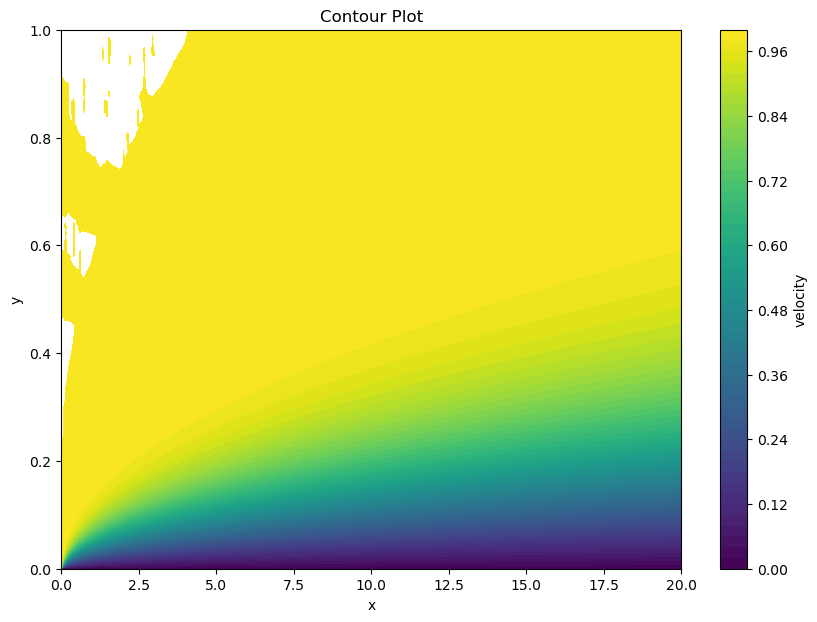

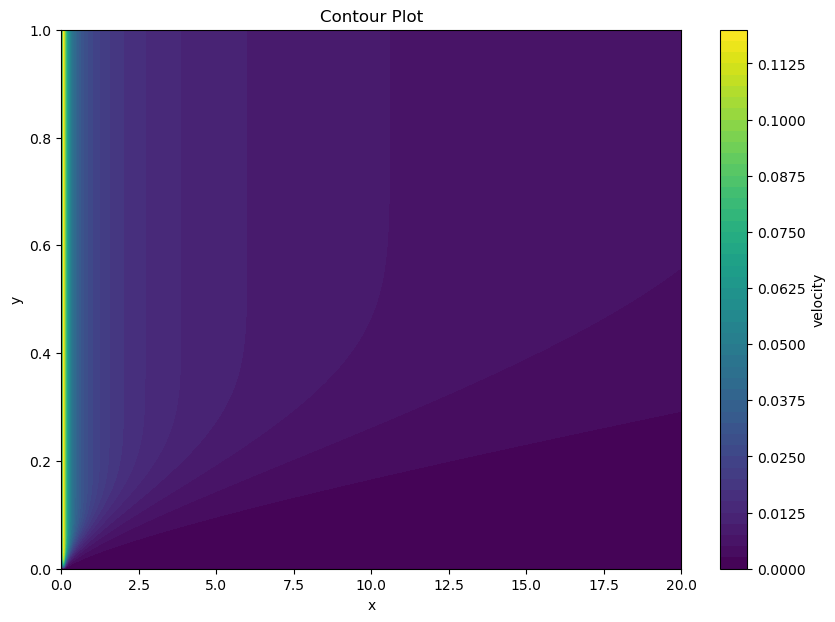

In [51]:
# Plot the final x-velocity contour
u,v = implicit_scheme()
contour(x,y,u,'u')
contour(x,y,v,'v')

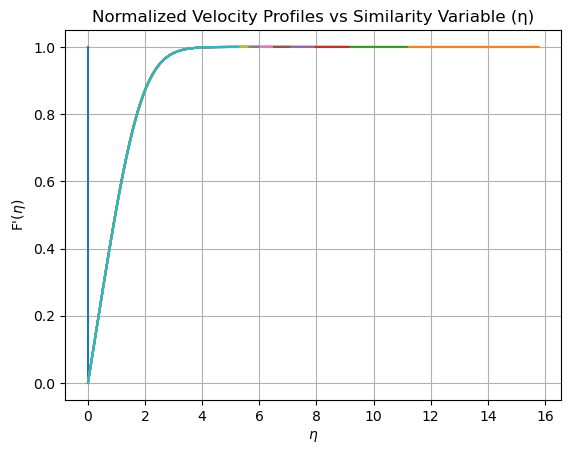

In [52]:
# Similarity variables for velocity profile
F_prime = np.zeros((Nx, Ny))  
eta = np.zeros((Nx, Ny))  

for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        eta[i, j]     = yj * np.sqrt(U_stream / (kin_vis * xi)) if xi != 0 else 0  
        F_prime[i, j] = u[i, j] / U_stream  

plt.figure()

for i in range(0, Nx, Nx // 10):
    plt.plot(eta[i, :], F_prime[i, :], label=f'x = {x[i]:.2f} m')

plt.xlabel(r'$\eta$')
plt.ylabel("F'($\eta$)")
plt.title("Normalized Velocity Profiles vs Similarity Variable (η)")
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_7740\2207237586.py:17: RuntimeWarning: invalid value encountered in divide
  delta_blasius = ((4.91 * x) / (np.sqrt(Rex)))


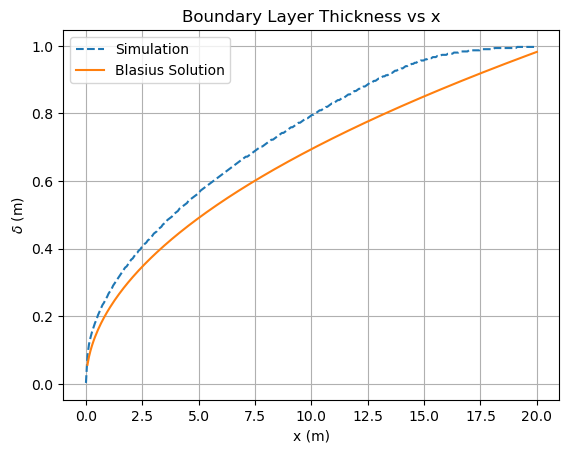

In [53]:
def thickness(u, y, U_stream, Nx, Ny):
    delta = np.zeros(Nx)  # to store boundary layer thickness at each x
    
    for i in range(Nx):
        delta_idx = np.where(u[i, :] >= 0.99999 * U_stream)[0]  
        if len(delta_idx) > 0:
            delta[i] = y[delta_idx[0]]
        else:
            delta[i] = L  
    return delta

# Compute boundary layer thickness from simulation
delta_simulation = thickness(u, y, U_stream, Nx, Ny)

# Blasius solution for comparison
Rex = (U_stream * x) / kin_vis 
delta_blasius = ((4.91 * x) / (np.sqrt(Rex)))

plt.figure()
plt.plot(x, delta_simulation, '--', label='Simulation')
plt.plot(x, delta_blasius, label='Blasius Solution')
plt.xlabel('x (m)')
plt.ylabel(r'$\delta$ (m)')
plt.title('Boundary Layer Thickness vs x')
plt.grid(True)
plt.legend()
plt.show()

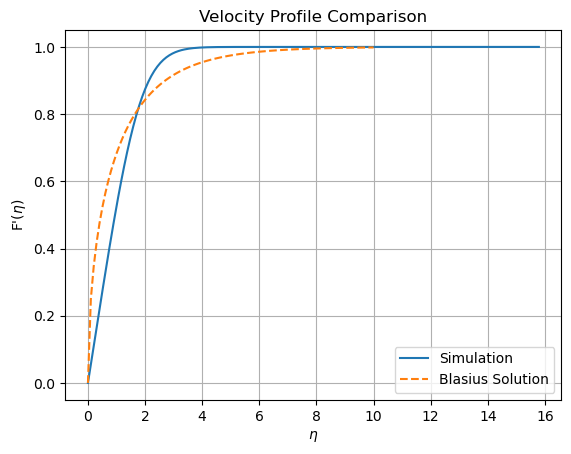

In [55]:
x_location = int(0.1 * Nx) 

# Normalized velocity profile F'(η)
F_prime_x = u[x_location, :] / U_stream  

# Similarity variable η
eta_x = y * np.sqrt(U_stream / (kin_vis * x[x_location]))

# Blasius solution
eta_blasius = np.linspace(0, 10, 100)
F_prime_blasius = erf(np.sqrt(eta_blasius / 2))

# Plot comparison
plt.figure()
plt.plot(eta_x, F_prime_x, label=f'Simulation')
plt.plot(eta_blasius, F_prime_blasius, '--', label='Blasius Solution')
plt.xlabel(r'$\eta$')
plt.ylabel("F'($\eta$)")
plt.title(f"Velocity Profile Comparison")
plt.grid(True)
plt.legend()
plt.show()
